# Random‑Unitary Circuits + Swap Test  
In [1], quantum simulation of Page curve in quantum gravity is simplified and mapped to quantum circuit model.
In this notebook, we are going to implement their swap-test implementation to generate Page curve from quantum simulation.
We demonstrate both the ideal and noisy simulations where early-FTQC articheture is used.

## 0 · Physical background: the Page curve and black‑hole evaporation

A black hole that evaporates by emitting Hawking radiation starts in a *pure* quantum state.
If we partition the full Hilbert space into the **radiation** subsystem $R(t)$ that has escaped up to time $t$
and the **remaining black‑hole** subsystem $B(t)$, then unitarity demands
$$S_{	ext{vN}}\bigl(\rho_{RB}(t)\bigr)=0,$$
yet each individual subsystem generically becomes *mixed*.
The **Page curve** is the time‑dependence of the entanglement entropy
$$S_R(t)=S_B(t)= -\operatorname{Tr}\bigl[\rho_R(t)\log\rho_R(t)\bigr]$$
as the evaporation progresses.

Page’s theorem [2] predicts that for a *random* pure state on
$\mathcal H_R\otimes\mathcal H_B$ with dimensions $d_R\le d_B$,
the *average* entropy of the smaller subsystem is

$$
\langle S_R \rangle
\;=\; \sum_{k=d_B+1}^{d_Rd_B} \frac{1}{k}
-\;\frac{d_R-1}{2d_B}
\;\approx\; \log d_R -\frac{d_R}{2d_B}.
$$

Applied to black holes, the entropy of the radiation increases linearly until roughly half the qubits have been emitted, after which it decreases, yielding the characteristic ``Page curve'' shape.

---


### Random‑unitary circuits as a toy model

Following [1], we model the scrambling dynamics of a black hole by a **random‑unitary circuit** (RUC):
nearest‑neighbour two‑qubit SU(4) gates chosen independently at every time layer.
After each layer, one qubit is traced out (``radiated'').
The **swap test** then lets us measure the second‑Rényi entropy
$$S_2(\rho)= -\log_2\,\operatorname{Tr}[\rho^2],$$
which approximates the von Neumann entropy for large Hilbert spaces.

In the sections below we first construct the RUC and the swap‑test
circuit, then sample over many random instances.
Finally, we compare the numerical average $\langle S_2\rangle$ with the analytic Page‑curve expectation above.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1217)  # reproducibility


## 1 · Define a random two‑qubit unitary `RandomSU4`  

We start with a helper OpSub that applies three random Pauli‑rotation layers, which together form a random element of SU(4).

In [2]:
from quri_parts.qsub.lib import std
from quri_parts.qsub.sub import SubBuilder
from quri_parts.qsub.opsub import ParamOpSubDef, param_opsub

class _RandomSU4(ParamOpSubDef[float, float, float]):
    """One SU(4) block parameterised by three Euler angles."""
    name = "RandomSU4"
    qubit_count = 2

    def sub(self, builder: SubBuilder, a: float, b: float, c: float) -> None:
        q0, q1 = builder.qubits
        for pauli_pair, theta in zip([(1,1), (2,2), (3,3)], (a, b, c)):
            builder.add_op(std.PauliRotation(pauli_pair, theta), (q0, q1))

# Factory function
RandomSU4, _ = param_opsub(_RandomSU4)


### 🔍 Preview • `RandomSU4`
A quick look at **one** two‑qubit SU(4) block.

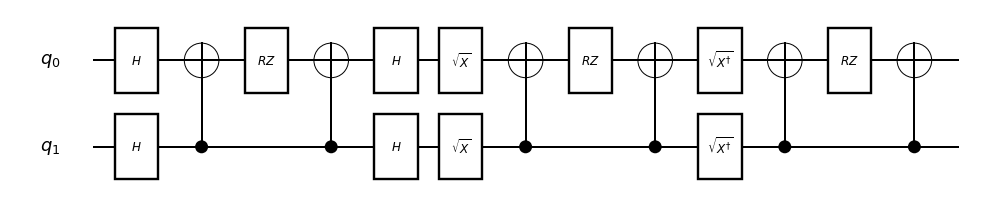

In [3]:

from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.primitive import AllBasicSet
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import QURIPartsEvaluatorHooks
from quri_parts.qulacs.circuit import convert_circuit
from qulacsvis import circuit_drawer

demo_sub = RandomSU4(*(2 * np.pi * np.random.rand(3)))
qc_demo = Evaluator(QURIPartsEvaluatorHooks()).run(
    compile_sub(resolve_sub(demo_sub), AllBasicSet)
)
# ASCII + Matplotlib render
circuit_drawer(convert_circuit(qc_demo), output_method="mpl")


## 2 · Build a random‑unitary circuit `RUC`  

We tile `RandomSU4` blocks in an **alternating even/odd pattern** so every nearest‑neighbour pair is eventually entangled.

In [4]:
class _RUC(ParamOpSubDef[int, int]):
    """Nearest‑neighbour random‑unitary circuit."""
    name = "RUC"

    def qubit_count_fn(self, n_qubits: int, _layers: int) -> int:
        return n_qubits

    def sub(self, builder: SubBuilder, n_qubits: int, n_layers: int) -> None:
        qs = builder.qubits
        for layer in range(n_layers):
            start = layer % 2
            for i in range(start, n_qubits - 1, 2):
                angles = 2 * np.pi * np.random.random(3)
                builder.add_op(RandomSU4(*angles), (qs[i], qs[i+1]))

RUC, _ = param_opsub(_RUC)


### 🔍 Preview • `RUC`
For example, a random‑unitary circuit on 4 qubits and 2 layers looks something as below. Each `RandomSU4` appears as a single opaque block.

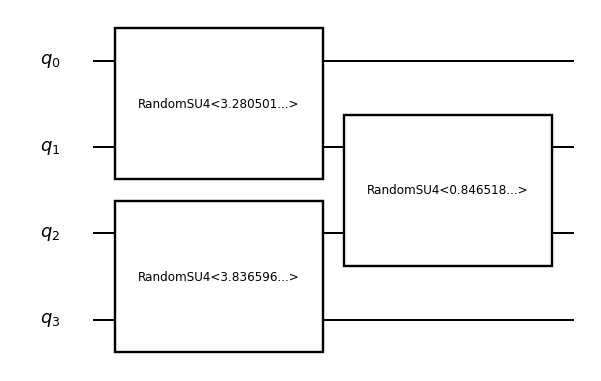

In [5]:
from quri_parts.qsub.visualize import draw_sub
from quri_parts.qsub.resolve import resolve_sub

# Symbolic (uncompiled) RUC on 4 qubits, 2 layers
ruc_demo_sym = resolve_sub(RUC(4, 2))
draw_sub(ruc_demo_sym)

## 3 · Swap test  

An ancilla qubit controls SWAPs between two scrambled copies of the system.  
Measuring the ancilla gives access to the **2‑Rényi entropy** of the subsystem selected by the SWAPs.
The circuit of swap test is illustrated below, and its implementation of the circuit as well.

In [6]:
class _SwapTest(ParamOpSubDef[int, int, int]):
    """Swap Test to estimate purity / Rényi‑2."""
    name = "SwapTest"

    def qubit_count_fn(self, n_system: int, *_):       # ancilla + 2 copies
        return 2 * n_system + 1

    def sub(self, builder: SubBuilder, n_system: int, n_layers: int, n_rad: int) -> None:
        qs = builder.qubits
        ancilla = qs[0]
        sysA = qs[1 : n_system + 1]
        sysB = qs[n_system + 1 : 2 * n_system + 1]

        builder.add_op(std.H, (ancilla,))
        builder.add_op(RUC(n_system, n_layers), sysA)
        builder.add_op(RUC(n_system, n_layers), sysB)

        for i in range(n_rad):
            builder.add_op(std.Controlled(std.SWAP), (ancilla, sysA[i], sysB[i]))

        builder.add_op(std.H, (ancilla,))

SwapTest, _ = param_opsub(_SwapTest)


### 🔍 Preview • `SwapTest`

This figure is the Fig. 8 of [1]

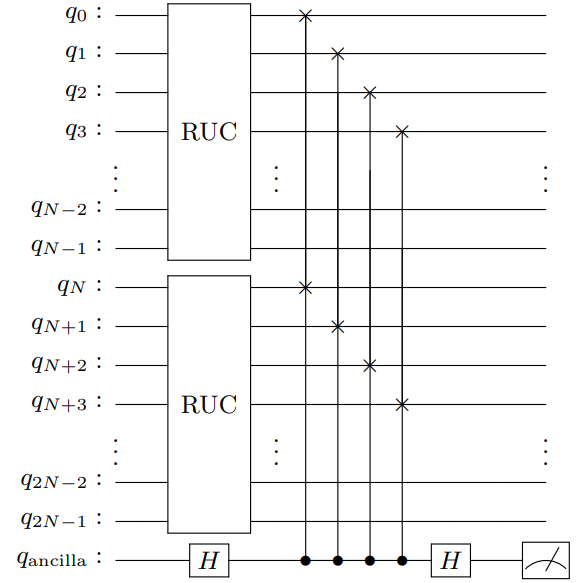

## 4 · Helper functions  

* `ancilla_hist` collapses outcome bit‑strings to ancilla results.  
* `renyi2` converts ancilla statistics to 2‑Rényi entropy.  
* `build_circuit` runs the qsub → primitive → Qulacs pipeline.

In [8]:
from collections import Counter, defaultdict
from quri_parts.qsub.resolve import resolve_sub
from quri_parts.qsub.compile import compile_sub
from quri_parts.qsub.primitive import AllBasicSet
from quri_parts.qsub.evaluate import Evaluator
from quri_parts.qsub.eval import QURIPartsEvaluatorHooks

def ancilla_zero_counts(counts: Counter[int]) -> Counter[int]:
    collapsed = defaultdict(int)
    for key, freq in counts.items():
        collapsed[key & 1] += freq    # LSB = ancilla
    return Counter(collapsed)

def renyi2_from_counts(counts: Counter[int], shots: int) -> float:
    p0 = counts[0] / shots
    purity = 2 * p0 - 1
    return -np.log(purity) if purity > 0 else np.inf

def build_qp_circuit(n_sys: int, n_layers: int, n_rad: int):
    resolved = resolve_sub(SwapTest(n_sys, n_layers, n_rad))
    compiled = compile_sub(resolved, AllBasicSet)
    evaluator = Evaluator(QURIPartsEvaluatorHooks())
    return evaluator.run(compiled)


## 5 · Run the experiment (now a helper function)

We wrap the sampling loop in **`run_entropy_scan`**.  
The function takes

* a `sampler` backend,
* system size `n_sys`,
* RUC depth `depth`,
* number of Monte‑Carlo realisations, and
* shots per circuit,

and returns both the `n_rad_list` and a matrix of 2‑Rényi entropies.


In [9]:
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler

def run_entropy_scan(
    sampler,
    n_sys: int,
    depth: int,
    n_real: int,
    n_shots: int,
):
    """Return (n_rad_list, entropy_matrix)."""
    n_rad_list = list(range(1, n_sys))
    entropy_matrix = np.zeros((n_real, len(n_rad_list)))  # realisations × n_rad

    for r in range(n_real):
        for j, n_rad in enumerate(n_rad_list):
            circuit = build_qp_circuit(n_sys, depth, n_rad)
            counts  = sampler(circuit, n_shots)

            # analyse ancilla
            collapsed = ancilla_zero_counts(counts)
            entropy_matrix[r, j] = renyi2_from_counts(collapsed, n_shots)

    return n_rad_list, entropy_matrix

# ---- Run the scan ----------------------------------------------------
N_SYS, DEPTH, N_REAL, N_SHOTS = 8, 8, 10, 10_000
sampler = create_qulacs_general_vector_sampler()

n_rad_list, entropy_matrix = run_entropy_scan(sampler, N_SYS, DEPTH, N_REAL, N_SHOTS)


## 6 · Visualise the average 2‑Rényi entropy

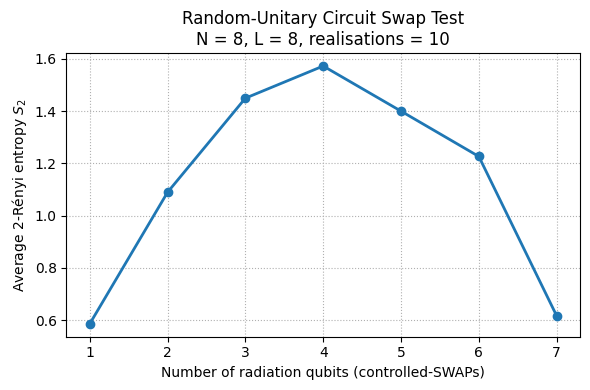

In [10]:
mean_entropy = entropy_matrix.mean(axis=0)
plt.figure(figsize=(6, 4))
plt.plot(n_rad_list, mean_entropy, "-o", linewidth=2, markersize=6)
plt.xlabel("Number of radiation qubits (controlled-SWAPs)")
plt.ylabel("Average 2-Rényi entropy $S_2$")
plt.title(f"Random-Unitary Circuit Swap Test\n"
          f"N = {N_SYS}, L = {DEPTH}, realisations = {N_REAL}")
plt.grid(True, which="both", linestyle=":")
plt.tight_layout()
plt.show()


## 5 bis · Analytic Page‑curve expectation

The Page formula can be specialised for an $n$‑qubit pure state whose first $n_R$ qubits have been radiated ($d_R=2^{n_R}$, $d_B=2^{n-n_R}$):

$$
\langle S_{\text{Page}}(n_R)\rangle
\;=\;\sum_{k=2^{n-n_R}+1}^{2^n} \frac{1}{k}
\;-\;\frac{2^{n_R}-1}{2^{n-n_R+1}}\;,
$$

which we implement below.
We will overlay this analytic curve with the numerically simulated
second‑Rényi entropy.


In [ ]:
def page_entropy_analytic(n_total: int, n_rad: int) -> float:
    """Average von Neumann entropy (base‑2) of a random pure state
    with n_rad qubits traced out (radiation) out of n_total qubits,
    according to Page's theorem.
    """
    import math
    d_R = 2 ** n_rad
    d_B = 2 ** (n_total - n_rad)
    # Ensure d_R <= d_B (swap if necessary due to symmetry S_R = S_B)
    if d_R > d_B:
        d_R, d_B = d_B, d_R
    harmonic_sum = sum(1 / k for k in range(d_B + 1, d_R * d_B + 1))
    return (harmonic_sum - (d_R - 1) / (2 * d_B)) / math.log(2)  # convert to bits


In [ ]:
analytic_curve = [page_entropy_analytic(n_total, n_r) for n_r in n_rad_list]
plt.figure(figsize=(6,4))
plt.plot(n_rad_list, mean_entropy, 'o-', label='Swap‑test ⟨S₂⟩ (sim.)')
plt.plot(n_rad_list, analytic_curve, 's--', label='Page formula ⟨S⟩ (analytic)')
plt.xlabel('Number of radiated qubits $n_R$')
plt.ylabel('Entropy [bits]')
plt.title('Page curve: simulation vs. analytic expectation')
plt.legend()
plt.grid(True)
plt.tight_layout()


## 7 · Hardware noise: resource estimation → **noisy entropy scan**

We now close the loop by *re‑running* **`run_entropy_scan`** under a
hardware‑derived noise model.

Workflow per physical error‑rate `p_phys`  
1. Create a star‑topology QPU description (code‑distance 9, 100 qubits).  
2. Let `VM.analyze` estimate logical fidelity.  
3. Build a Qulacs **Kraus‑noise sampler** from the same noise model.  
4. Call `run_entropy_scan` to obtain the *full* 2‑Rényi entropy curve
   `S₂(n_rad)` under noise.  

Finally we overlay the noisy curves with the noiseless baseline so you can
see how entanglement estimation deteriorates as physical error increases.


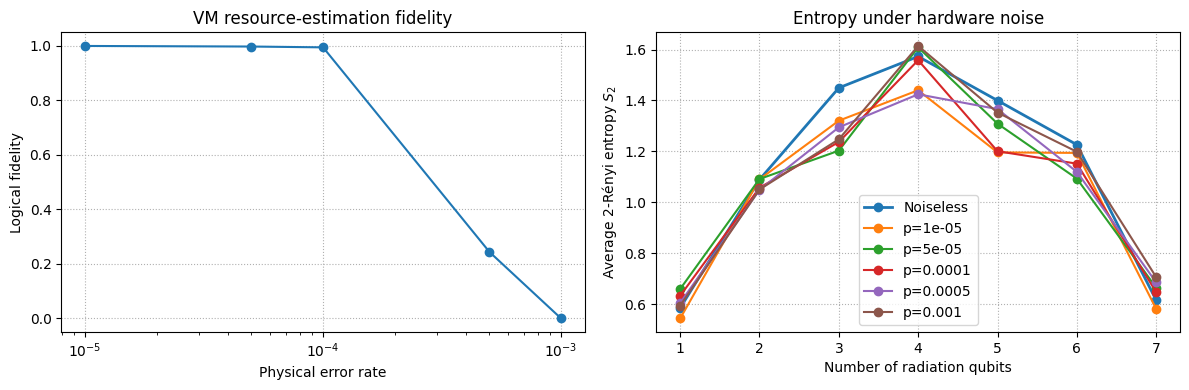

In [ ]:
from quri_parts.backend.devices import star_device
from quri_vm import VM
from quri_parts.backend.units import TimeUnit, TimeValue
from quri_parts.qulacs.sampler import (
    create_qulacs_noisesimulator_general_sampler,
    create_qulacs_density_matrix_general_sampler,
)

# --- Noise sweep parameters -------------------------------------------
noise_levels = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

fidelities       = []
entropy_curves   = []   # mean S2 vs n_rad for each noise level

for p_phys in noise_levels:
    # 1) Device + VM analysis
    star_qpu = star_device.generate_device_property(
        qubit_count=100,
        code_distance=9,
        qec_cycle=TimeValue(1, TimeUnit.MICROSECOND),
        physical_error_rate=p_phys,
    )
    star_vm = VM.from_device_prop(star_qpu)
    analysis = star_vm.analyze(build_qp_circuit(N_SYS, DEPTH, N_SYS // 2))
    fidelities.append(analysis.fidelity)

    # 2) Noisy sampler (Kraus model)
    noisy_sampler = create_qulacs_noisesimulator_general_sampler(star_qpu.noise_model)

    # 3) Run full entropy scan under noise
    n_rad_list, entropy_mat = run_entropy_scan(
        noisy_sampler, N_SYS, DEPTH, N_REAL, N_SHOTS
    )
    entropy_curves.append(entropy_mat.mean(axis=0))

# --- Plotting ----------------------------------------------------------
# Figure A: logical fidelity vs physical error rate
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].semilogx(noise_levels, fidelities, '-o')
axes[0].set_xlabel('Physical error rate')
axes[0].set_ylabel('Logical fidelity')
axes[0].set_title('VM resource‑estimation fidelity')
axes[0].grid(True, ls=':')

# Figure B: noisy entropy curves + noiseless baseline
# Baseline from earlier Section 6
baseline = entropy_matrix.mean(axis=0)
axes[1].plot(n_rad_list, baseline, '-o', label='Noiseless', linewidth=2)

for curve, p in zip(entropy_curves, noise_levels):
    axes[1].plot(n_rad_list, curve, '-o', label=f'p={p}')

axes[1].set_xlabel('Number of radiation qubits')
axes[1].set_ylabel('Average 2‑Rényi entropy $S_2$')
axes[1].set_title('Entropy under hardware noise')
axes[1].grid(True, ls=':')
axes[1].legend()

plt.tight_layout()
plt.show()

# Example: density‑matrix sampler (not used here, but available)
_ = create_qulacs_density_matrix_general_sampler(star_qpu.noise_model)


## References

[1] A. Chowdhury, N. Engelhardt, M. Mezei, A. Rolph, *Page Curves from Random‑Unitary Circuits and the Analytic Second‑Rényi Entropy*, arXiv:2412.15180 (2024).

[2] D. N. Page, *Information in Black Hole Radiation*, **Phys. Rev. Lett.** 71, 3743 (1993).

